In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
#import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.patches as patches
import os
import cartopy.mpl.ticker as cticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import re
import datetime
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import datetime
from matplotlib.colors import ListedColormap
from matplotlib.colors import TwoSlopeNorm

In [120]:
########################################################### load climatology dataset ############################################################
clim_t850 = xr.open_dataset('/home/kit/imk-tro/gj5173/tmp/clim_T85000_30day_centered_on_0629_1979-2020_-180.0--60.0degE_25.0-80.0degN_by_grid_point',engine = 'netcdf4')

In [5]:
clim_t850

<xarray.Dataset>
Dimensions:  (lon: 240, lat: 110)
Coordinates:
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... -61.5 -61.0 -60.5
  * lat      (lat) float32 25.0 25.5 26.0 26.5 27.0 ... 77.5 78.0 78.5 79.0 79.5
    plev     float64 ...
Data variables:
    T        (lat, lon) float32 289.2 289.1 289.1 289.0 ... 271.4 271.3 271.2

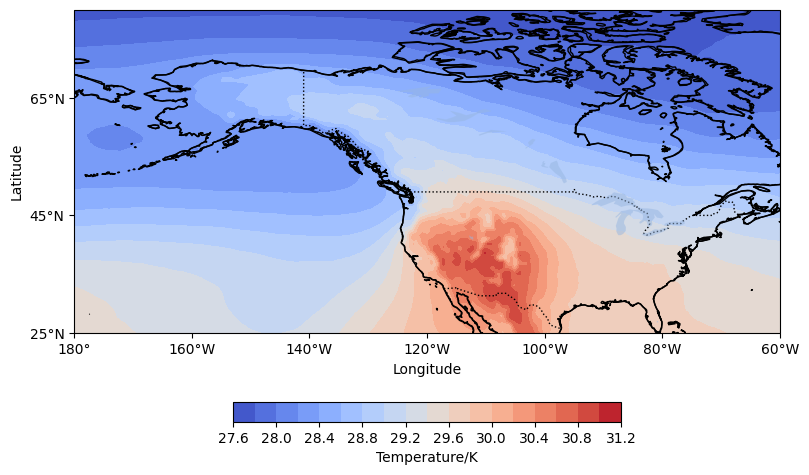

In [3]:
#check for the distribution of climatology of t850



lat = np.linspace(25, 80, 110)
lon = np.linspace(-180, -60, 240)
lon_grid, lat_grid = np.meshgrid(lon, lat)


fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
x, y = lon_grid, lat_grid  
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
                  
# Add map 
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='w')


ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())

lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Plot the contour map
contour1 = ax.contourf(x,y,clim_t850.T/9.80665,cmap='coolwarm',levels=20)
cbar = plt.colorbar(contour1, ax=ax, label='Temperature/K',orientation='horizontal',shrink=0.5)

# Set plot title and labels

plt.xlabel('Longitude')
plt.ylabel('Latitude')

#plt.savefig('/home/kit/imk-tro/gj5173/plots07.27/climatology.png', bbox_inches='tight',dpi=100)
# Show the plot
plt.show()

In [ ]:
##################################### read the era5 data -- t2m, t850, z500 ##############################################################################

In [121]:
ds_era = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/era5/2021.h5')
ds_era5_t2m_na = ds_era.fields[656:737:4,2,260:40:-1,720:1200]
ds_era5_t850_na = ds_era.fields[656:737:4,5,260:40:-1,720:1200]
ds_era5_z500_na = ds_era.fields[656:737:4,14,260:40:-1,720:1200]
ds_era5_t2m_na_0629 = ds_era5_t2m_na[15,:,:]
ds_era5_t850_na_0629 = ds_era5_t850_na[15,:,:]
ds_era5_z500_na_0629 = ds_era5_z500_na[15,:,:]
ds_era5_t2m_box_mean = np.mean(ds_era5_t2m_na[:,61:141,194:274], axis=(1, 2))
ds_era5_t850_box_mean = np.mean(ds_era5_t850_na[:,61:141,194:274], axis=(1, 2))
ds_era5_z500_box_mean = np.mean(ds_era5_z500_na[:,61:141,194:274], axis=(1, 2))

ds_era5_t2m_box_0629_mean = ds_era5_t2m_box_mean[15]
ds_era5_t850_box_0629_mean = ds_era5_t850_box_mean[15]
ds_era5_z500_box_0629_mean = ds_era5_z500_box_mean[15]

In [122]:
#interpolate function here,should incorporate with other variable later 
def interpolate_function(original_data,target_shape):
    #interpolate from (220,480) to (110,240) 
    #original_data = ds_era_z500
    
    # Define the original grid points along the last two dimensions
    x_orig = np.arange(list(np.shape(original_data))[-2])
    y_orig = np.arange(list(np.shape(original_data))[-1])
    
    # Define the new grid points along the last two dimensions
    y_new = np.linspace(0, list(np.shape(original_data))[-1] - 1, list(np.shape(target_shape.T))[-1])  
    x_new = np.linspace(0, list(np.shape(original_data))[-2]- 1, list(np.shape(target_shape.T))[-2])
    
    
    interpolated_data = original_data.interp(coords={list(original_data.dims)[-2]: x_new, list(original_data.dims)[-1]: y_new}, method='cubic')
    return interpolated_data


In [123]:
#interpolate the era5 data onto the climatology data 
ds_era5_t850_na_0629_interpolated = interpolate_function(ds_era5_t850_na_0629,clim_t850)

In [124]:
def calculate_batch_difference(v1, v2, batch_size):
    """
    Calculate the point-wise difference between two arrays (v2 - v1) in batches.

    Parameters:
    - v1: The first input array.
    - v2: The second input array.
    - batch_size: The desired batch size for processing.

    Returns:
    - An array containing the point-wise differences between v2 and v1.
    """
    # Get the shape of the input arrays
    rows, cols = v1.shape
    
    # Initialize the difference array
    difference = np.empty((rows, cols))

    for i in range(0, rows, batch_size):
        for j in range(0, cols, batch_size):
            batch_variable1 = v1[i:i + batch_size, j:j + batch_size]
            batch_variable2 = v2[i:i + batch_size, j:j + batch_size]
            
            # Calculate the difference point by point for the current batch
            batch_difference = batch_variable2 - batch_variable1

            # Update the difference array with the current batch_difference
            difference[i:i + batch_size, j:j + batch_size] = batch_difference

    return difference

In [125]:
#calculate the anomaly by batch difference function

v2 = ds_era5_t850_na_0629_interpolated
v1 = clim_t850.T[:,:].values

anomaly_era5_t850_na_0629_interpolated = calculate_batch_difference(v1, v2, 50)


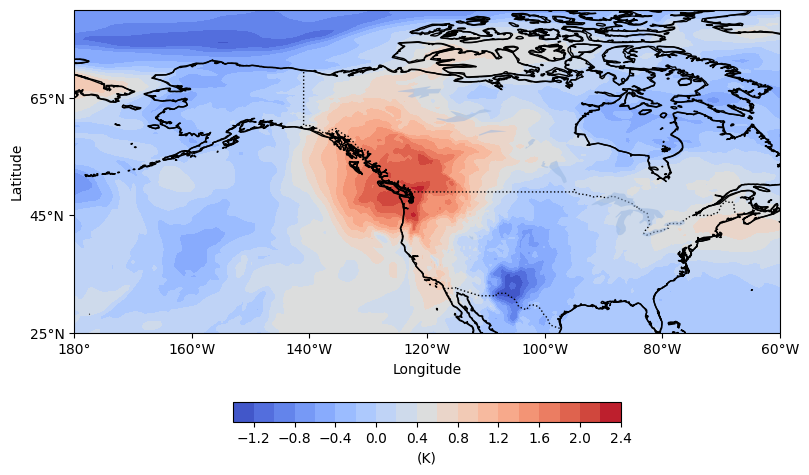

In [126]:
#check the anomaly distribution
lat = np.linspace(25, 80, 110)
lon = np.linspace(-180, -60, 240)
lon_grid, lat_grid = np.meshgrid(lon, lat)


fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
x, y = lon_grid, lat_grid  
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
                  
# Add map 
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='w')


ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())

lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Plot the contour map

#contour1 = ax.contourf(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665,cmap='coolwarm',levels=20)
contour1 = ax.contourf(x,y, anomaly_era5_t850_na_0629_interpolated/9.80665,cmap='coolwarm',levels=20)
cbar = plt.colorbar(contour1, ax=ax, label='(K)',orientation='horizontal',shrink=0.5)

# Set plot title and labels

plt.xlabel('Longitude')
plt.ylabel('Latitude')

#plt.savefig('/home/kit/imk-tro/gj5173/plots07.27/climatology.png', bbox_inches='tight',dpi=100)
# Show the plot
plt.show()

In [ ]:
############################################## load the ECMWF data---control forecast ############################################################

In [15]:
def read_and_choose_variable_ec(directory, filename_pattern, variable_name, level ):
    # Read data and choose the variable
    files = sorted([f for f in os.listdir(directory) if re.match(filename_pattern, f)])
    variable_data_list = []

    for file in files:
        file_path = os.path.join(directory, file)
        ds = xr.open_dataset(file_path)
        if level is not None:
            variable_data = ds[variable_name][:, level, :, :]
        else:
            variable_data = ds[variable_name]

        variable_data_list.append(variable_data)

    ds_variable_na = xr.DataArray(variable_data_list)

    return ds_variable_na

In [16]:
def process_target_forecast(ds, start_index, step_size, num_iterations):
    'choose the certain date and lead time and get the target forecast'
    ds_target_forecast = []
    for i in range(num_iterations):
        ec_value = ds[(i + 1) * step_size, start_index - i * step_size * 4, :, :]
        ds_target_forecast.append(ec_value)

    ds_target_forecast = xr.DataArray(ds_target_forecast)

    return ds_target_forecast
'''#usage example
start_index = 56
step_size = 1
num_iterations = 15
ds=ds_ec_t2m_box
ds_ec_t2m_box_0629 = process_target_forecast(ds, start_index, step_size, num_iterations)'''

'#usage example\nstart_index = 56\nstep_size = 1\nnum_iterations = 15\nds=ds_ec_t2m_box\nds_ec_t2m_box_0629 = process_target_forecast(ds, start_index, step_size, num_iterations)'

In [17]:
#read data and choose variable----t850
directory = '/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/'
filename_pattern = r'fc_cf_\d{8}_\d{2}_pl\.nc'
variable_name = 't'
level = 1  # 850hpa
ds_ec_t850_na = read_and_choose_variable_ec(directory, filename_pattern, variable_name, level)
#ds_ec_z500_na_0629
#choose the box
ds_ec_t850_box=ds_ec_t850_na[:,:,79:159,194:274]

In [18]:
#choose the target day in the whole NA area
start_index = 56
step_size = 1
num_iterations = 15
ds=ds_ec_t850_na
ds_ec_t850_na_0629 = process_target_forecast(ds, start_index, step_size, num_iterations)

In [ ]:
########################################## load the ECMWF data ----- predictability froecast ########################################################

In [19]:
ds_ec_1 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210615_00_pl.nc') 
variable_data_ec_1 = ds_ec_1['t'][56,:,1,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_2 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210616_00_pl.nc') 
variable_data_ec_2 = ds_ec_2['t'][52,:,1,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_3 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210617_00_pl.nc') 
variable_data_ec_3 = ds_ec_3['t'][48,:,1,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_4 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210618_00_pl.nc') 
variable_data_ec_4 = ds_ec_4['t'][44,:,1,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_5 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210619_00_pl.nc') 
variable_data_ec_5 = ds_ec_5['t'][40,:,1,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_6 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210620_00_pl.nc') 
variable_data_ec_6 = ds_ec_6['t'][36,:,1,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_7 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210621_00_pl.nc') 
variable_data_ec_7 = ds_ec_7['t'][32,:,1,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_8 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210622_00_pl.nc') 
variable_data_ec_8 = ds_ec_8['t'][28,:,1,:,:]

ds_ec_9 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210623_00_pl.nc') 
variable_data_ec_9 = ds_ec_9['t'][24,:,1,:,:]

ds_ec_10 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210624_00_pl.nc') 
variable_data_ec_10 = ds_ec_10['t'][20,:,1,:,:]

ds_ec_11 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210625_00_pl.nc') 
variable_data_ec_11 = ds_ec_11['t'][16,:,1,:,:]

ds_ec_12 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210626_00_pl.nc') 
variable_data_ec_12 = ds_ec_12['t'][12,:,1,:,:]

ds_ec_13 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210627_00_pl.nc') 
variable_data_ec_13 = ds_ec_13['t'][8,:,1,:,:]

ds_ec_14 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210628_00_pl.nc') 
variable_data_ec_14 = ds_ec_14['t'][4,:,1,:,:]

ds_ec_15 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/fc_pf_20210629_00_pl.nc') 
variable_data_ec_15 = ds_ec_15['t'][0,:,1,:,:]

In [20]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [13]})

In [21]:
ds_ec_t850_na_0629_ens = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

/home/kit/imk-tro/gj5173/anaconda3/envs/newenvi1/lib/python3.9/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [22]:
ds_ec_t850_na_0629_ens = xr.DataArray(ds_ec_t850_na_0629_ens)

In [27]:
#interpolate function here,should incorporate with other variable later 
def interpolate_ecmwf_function(original_data,target_shape):
    #interpolate from (220,480) to (110,240) 
    #original_data = ds_era_z500
    
    # Define the original grid points along the last two dimensions
    x_orig = np.arange(25,80,list(np.shape(original_data))[-2])
    y_orig = np.arange(-180,-60,list(np.shape(original_data))[-1])
    
    # Define the new grid points along the last two dimensions
    y_new = np.linspace(-180,-60,  list(np.shape(target_shape.T))[-1])  
    x_new = np.linspace(25,80,  list(np.shape(target_shape.T))[-2])
    
    
    interpolated_data = original_data.interp(coords={list(original_data.dims)[-2]: x_new, list(original_data.dims)[-1]: y_new}, method='cubic')
    return interpolated_data


In [28]:
#interpolate the ecmwf_cf onto the climatology
ds_ec_t850_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
for i in range(15):
    ds_ec_t850_na_0629_interpolated[i,:,:] = interpolate_function(ds_ec_t850_na_0629[i,:,:],clim_t850)
    

In [29]:
#interpolate the ecmwf_ens onto the climatology !!!!!!!Kernel always die
ds_ec_t850_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
for i in range(15):
    for j in range(50):
        ds_ec_t850_na_0629_ens_interpolated[i,j,:,:] = interpolate_ecmwf_function(ds_ec_t850_na_0629_ens[i,j,:,:],clim_t850)

In [30]:
%store -r ds_ec_t850_na_0629_ens_interpolated

Stored 'ds_ec_t850_na_0629_ens_interpolated' (ndarray)


In [31]:
#use the small batch to calculate the anomaly of ec_cf

anomaly_ec_t850_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
v2 = ds_ec_t850_na_0629_interpolated
v1 = clim_t850.T[:,:]
for i in range(15):
    anomaly_ec_t850_na_0629_interpolated[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:],50)
#########################!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#######################################
#the reason here might be the latitude oder when you interpolate, go check it

In [32]:
#use the small batch to calculate the anomaly of ec_ens

anomaly_ec_t850_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
v2 = ds_ec_t850_na_0629_ens_interpolated
v1 = clim_t850.T[:,:].values
for i in range(15):
    for j in range(50):
        anomaly_ec_t850_na_0629_ens_interpolated[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,:,:], 50)

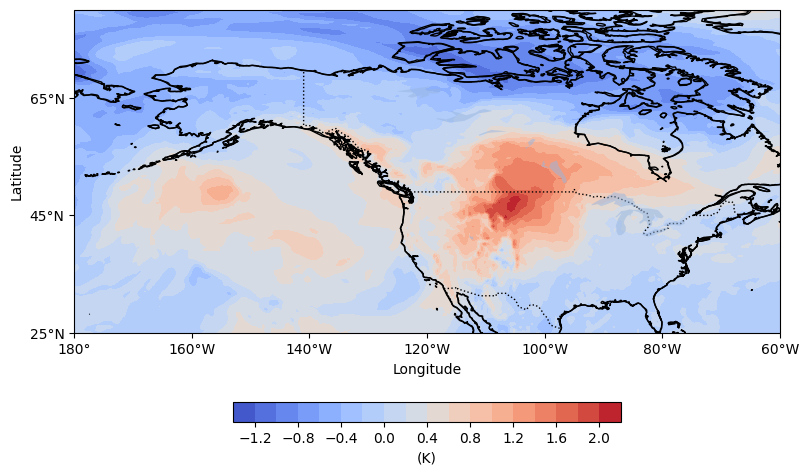

In [34]:
#check the anomaly distribution
lat = np.linspace(25, 80, 110)
lon = np.linspace(-180, -60, 240)
lon_grid, lat_grid = np.meshgrid(lon, lat)


fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
x, y = lon_grid, lat_grid  
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
                  
# Add map 
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='w')


ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())

lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Plot the contour map

#contour1 = ax.contourf(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665,cmap='coolwarm',levels=20)
contour1 = ax.contourf(x,y, anomaly_ec_t850_na_0629_interpolated[1,:,:]/9.80665,cmap='coolwarm',levels=20)
cbar = plt.colorbar(contour1, ax=ax, label='(K)',orientation='horizontal',shrink=0.5)

# Set plot title and labels

plt.xlabel('Longitude')
plt.ylabel('Latitude')

#plt.savefig('/home/kit/imk-tro/gj5173/plots07.27/climatology.png', bbox_inches='tight',dpi=100)
# Show the plot
plt.show()

In [ ]:
#################################################### load the fcnv1_ecmwf data #############################################################################

In [141]:
ds_ec_1 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210615_00_backtransformed.nc') 
variable_data_ec_1 = ds_ec_1['forecast'][:,56,5,:,:]

ds_ec_2 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210616_00_backtransformed.nc') 
variable_data_ec_2 = ds_ec_2['forecast'][:,52,5,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_3 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210617_00_backtransformed.nc') 
variable_data_ec_3 = ds_ec_3['forecast'][:,48,5,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_4 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210618_00_backtransformed.nc') 
variable_data_ec_4 = ds_ec_4['forecast'][:,44,5,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_5 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210619_00_backtransformed.nc') 
variable_data_ec_5 = ds_ec_5['forecast'][:,40,5,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_6 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210620_00_backtransformed.nc') 
variable_data_ec_6 = ds_ec_6['forecast'][:,36,5,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_7 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210621_00_backtransformed.nc') 
variable_data_ec_7 = ds_ec_7['forecast'][:,32,5,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))

ds_ec_8 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210622_00_backtransformed.nc') 
variable_data_ec_8 = ds_ec_8['forecast'][:,28,5,:,:]

ds_ec_9 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210623_00_backtransformed.nc') 
variable_data_ec_9 = ds_ec_9['forecast'][:,24,5,:,:]

ds_ec_10 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210624_00_backtransformed.nc') 
variable_data_ec_10 = ds_ec_10['forecast'][:,20,5,:,:]

ds_ec_11 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210625_00_backtransformed.nc') 
variable_data_ec_11 = ds_ec_11['forecast'][:,16,5,:,:]

ds_ec_12 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210626_00_backtransformed.nc') 
variable_data_ec_12 = ds_ec_12['forecast'][:,12,5,:,:]

ds_ec_13 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210627_00_backtransformed.nc') 
variable_data_ec_13 = ds_ec_13['forecast'][:,8,5,:,:]

ds_ec_14 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210628_00_backtransformed.nc') 
variable_data_ec_14 = ds_ec_14['forecast'][:,4,5,:,:]
ds_ec_15 = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/20210629_00_backtransformed.nc') 
variable_data_ec_15 = ds_ec_15['forecast'][:,0,5,:,:]

In [142]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [14]})

In [143]:
ds_fcnv1_ec_t850_na_0629_ens = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

/home/kit/imk-tro/gj5173/anaconda3/envs/newenvi1/lib/python3.9/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [144]:
ds_fcnv1_ec_t850_na_0629 = ds_fcnv1_ec_t850_na_0629_ens[:,50,:,:]
ds_fcnv1_ec_t850_na_ens_0629 = ds_fcnv1_ec_t850_na_0629_ens[:,0:50,:,:]

In [145]:
#interpolate the fcnv1_ec_cf onto the climatology
ds_fcnv1_ec_t850_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
for i in range(15):
    ds_fcnv1_ec_t850_na_0629_interpolated[i,:,:] = interpolate_function(ds_fcnv1_ec_t850_na_0629[i,:,:],clim_t850)

In [42]:
#interpolate the fcnv1_ec_ens onto the climatology !!!!!careful with kernel die
ds_fcnv1_ec_t850_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
for i in range(15):
    for j in range(50):
        ds_fcnv1_ec_t850_na_0629_ens_interpolated[i,j,:,:] = interpolate_function(ds_fcnv1_ec_t850_na_ens_0629[i,j,:,:],clim_t850)

In [43]:
%store -r ds_fcnv1_ec_t850_na_0629_ens_interpolated

Stored 'ds_fcnv1_ec_t850_na_0629_ens_interpolated' (ndarray)


In [149]:
#use the small batch to calculate the anomaly of fcnv1_ec_cf

anomaly_fcnv1_ec_t850_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
v2 = ds_fcnv1_ec_t850_na_0629_interpolated
v1 = clim_t850.T[:,:]
for i in range(15):
    anomaly_fcnv1_ec_t850_na_0629_interpolated[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:],50)


In [46]:
#use the small batch to calculate the anomaly of fcnv1_ec_ens

anomaly_fcnv1_ec_t850_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
v2 = ds_fcnv1_ec_t850_na_0629_ens_interpolated
v1 = clim_t850.T[:,:].values
for i in range(15):
    for j in range(50):
        anomaly_fcnv1_ec_t850_na_0629_ens_interpolated[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,::-1,:], 50)

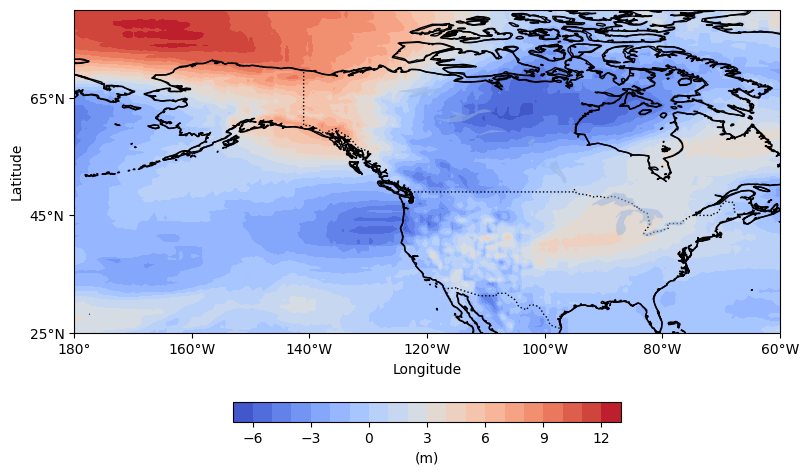

In [47]:
#check the anomaly distribution
lat = np.linspace(25, 80, 110)
lon = np.linspace(-180, -60, 240)
lon_grid, lat_grid = np.meshgrid(lon, lat)


fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
x, y = lon_grid, lat_grid  
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
                  
# Add map 
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='w')


ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())

lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Plot the contour map

#contour1 = ax.contourf(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665,cmap='coolwarm',levels=20)
contour1 = ax.contourf(x,y, anomaly_fcnv1_ec_t850_na_0629_ens_interpolated[0,0,:,:],cmap='coolwarm',levels=20)
cbar = plt.colorbar(contour1, ax=ax, label='(m)',orientation='horizontal',shrink=0.5)

# Set plot title and labels

plt.xlabel('Longitude')
plt.ylabel('Latitude')

#plt.savefig('/home/kit/imk-tro/gj5173/plots07.27/climatology.png', bbox_inches='tight',dpi=100)
# Show the plot
plt.show()

In [ ]:
################### load fcnv1_era data ############################################################################

In [131]:
#fcn_era5
ds_fcn_era = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data//fourcastnet/2021_dt_list_ens_backtransformed.nc',engine = 'netcdf4')
ds_fcn_era
fcn_era_z = ds_fcn_era.forecast[:,:,:,5,:,:]

variable_data_ec_1 = fcn_era_z[1,:,56,:,:]


variable_data_ec_2 = fcn_era_z[2,:,52,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))


variable_data_ec_3 = fcn_era_z[3,:,48,:,:]

variable_data_ec_4 = fcn_era_z[4,:,44,:,:]

variable_data_ec_5 = fcn_era_z[5,:,40,:,:]

variable_data_ec_6 = fcn_era_z[6,:,36,:,:]

variable_data_ec_7 = fcn_era_z[7,:,32,:,:]

variable_data_ec_8 = fcn_era_z[8,:,28,:,:]

variable_data_ec_9 = fcn_era_z[9,:,24,:,:]

variable_data_ec_10 = fcn_era_z[10,:,20,:,:]

variable_data_ec_11 = fcn_era_z[12,:,16,:,:]

variable_data_ec_12 = fcn_era_z[13,:,12,:,:]

variable_data_ec_13 = fcn_era_z[14,:,8,:,:]

variable_data_ec_14 = fcn_era_z[15,:,4,:,:]

variable_data_ec_15 = fcn_era_z[16,:,0,:,:]

In [132]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [14]})

In [133]:
ds_fcnv1_era_t850_na_0629_ens = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

/home/kit/imk-tro/gj5173/anaconda3/envs/newenvi1/lib/python3.9/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [134]:
ds_fcnv1_era_t850_na_0629 = ds_fcnv1_era_t850_na_0629_ens[:,0,:,:]
ds_fcnv1_era_t850_na_ens_0629 = ds_fcnv1_era_t850_na_0629_ens[:,1:51,:,:]

In [135]:
#interpolate the fcnv1_era_cf onto the climatology
ds_fcnv1_era_t850_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
for i in range(15):
    ds_fcnv1_era_t850_na_0629_interpolated[i,:,:] = interpolate_function(ds_fcnv1_era_t850_na_0629[i,:,:],clim_t850)

In [53]:
#interpolate the fcnv1_ec_ens onto the climatology !!!!!!!!careful with the kernel dead issue
ds_fcnv1_era_t850_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
for i in range(15):
    for j in range(50):
        ds_fcnv1_era_t850_na_0629_ens_interpolated[i,j,:,:] = interpolate_function(ds_fcnv1_era_t850_na_ens_0629[i,j,:,:],clim_t850)

In [129]:
%store -r ds_fcnv1_era_t850_na_0629_ens_interpolated

In [127]:
%store -r ds_fcnv1_era_z500_na_0629_ens_interpolated
%store -r anomaly_era5_z500_na_0629_interpolated
%store -r anomaly_fcnv1_era_z500_na_0629_ens_interpolated

In [136]:
#use the small batch to calculate the anomaly of fcnv1_ec_cf

anomaly_fcnv1_era_t850_na_0629_interpolated = np.zeros((15,110,240),dtype=float)
v2 = ds_fcnv1_era_t850_na_0629_interpolated
v1 = clim_t850.T[:,:]
for i in range(15):
    anomaly_fcnv1_era_t850_na_0629_interpolated[i,:,:] = calculate_batch_difference(v1,v2[i,::-1,:],50)


In [7]:
#use the small batch to calculate the anomaly of fcnv1_ec_ens

anomaly_fcnv1_era_t850_na_0629_ens_interpolated = np.zeros((15,50,110,240),dtype=float)
v2 = ds_fcnv1_era_t850_na_0629_ens_interpolated
v1 = clim_t850.T[:,:].values
for i in range(15):
    for j in range(50):
        anomaly_fcnv1_era_t850_na_0629_ens_interpolated[i,j,:,:] = calculate_batch_difference(v1,v2[i,j,::-1,:], 50)

In [ ]:
######################## good and bad memebers checking #################################

In [112]:
#check the good and bad memeber of the 
from numpy import zeros, newaxis
rmse_per_member = np.zeros((50),dtype=object)
np.shape(anomaly_fcnv1_era_z500_na_0629_ens_interpolated)
#np.shape(anomaly_era5_t850_na_0629_interpolated)

# Iterate through each member for the lead time of 2 days(Why the suddenly drop)
for j in range(50):
    rmse_per_member[j] = np.sqrt(np.mean((anomaly_fcnv1_era_z500_na_0629_ens_interpolated[12, j, :, :] - anomaly_era5_z500_na_0629_interpolated)**2))

In [113]:
rmse_flattened = rmse_per_member.flatten()

rmse_30 = np.percentile(rmse_flattened,30)
rmse_70 = np.percentile(rmse_flattened,70)
rmse_70

below_30th_percentile = rmse_per_member < rmse_30
above_70th_percentile = rmse_per_member > rmse_70
good_forecast_index = np.where(rmse_per_member < rmse_30)
bad_forecast_index = np.where(rmse_per_member > rmse_70)

In [114]:
bad_forecast_index

(array([ 5,  6, 11, 12, 14, 19, 20, 22, 23, 24, 26, 31, 36, 42, 45]),)

In [115]:
good_forecast_index
bad_forecast_12 = anomaly_fcnv1_era_z500_na_0629_ens_interpolated[12,bad_forecast_index[0][:],:,:]
good_forecast_12 = anomaly_fcnv1_era_z500_na_0629_ens_interpolated[12,good_forecast_index[0][:],:,:]

In [116]:
np.shape(bad_forecast_12)
bad_forecast_12_mean = np.mean(bad_forecast_12,axis=(0))
good_forecast_12_mean = np.mean(good_forecast_12,axis=(0))
np.shape(bad_forecast_12_mean)

(110, 240)

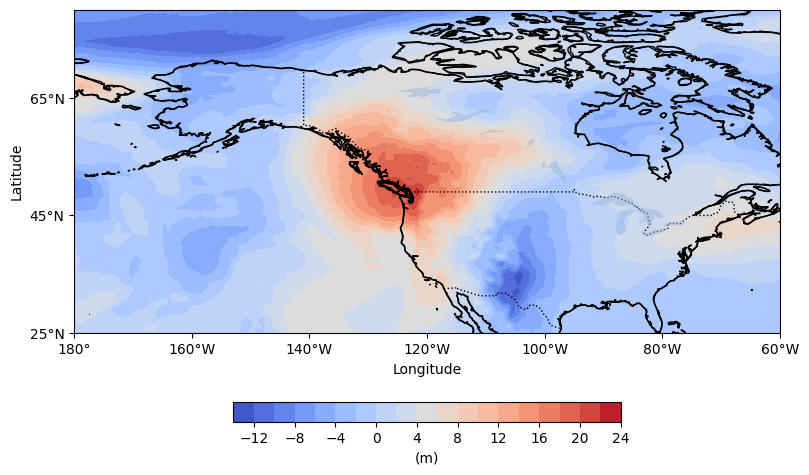

In [164]:
#check the anomaly distribution
lat = np.linspace(25, 80, 110)
lon = np.linspace(-180, -60, 240)
lon_grid, lat_grid = np.meshgrid(lon, lat)


fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
x, y = lon_grid, lat_grid  
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
                  
# Add map 
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='w')


ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())

lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Plot the contour map

#contour1 = ax.contourf(x,y,anomaly_era5_z500_na_0629_interpolated/9.80665,cmap='coolwarm',levels=20)
contour1 = ax.contourf(x,y,anomaly_fcnv1_ec_t850_na_0629_interpolated[13,:,:],cmap='coolwarm',levels=20)

cbar = plt.colorbar(contour1, ax=ax, label='(m)',orientation='horizontal',shrink=0.5)

# Set plot title and labels

plt.xlabel('Longitude')
plt.ylabel('Latitude')

#plt.savefig('/home/kit/imk-tro/gj5173/plots07.27/climatology.png', bbox_inches='tight',dpi=100)
# Show the plot
plt.show()

In [ ]:
#################################################### Calculate the ACC(simpler without the function) ################################################

In [61]:
#acc_ec_box_cf

acc_ec_t850_box_0629 = np.empty(15)
acc_ec_t850_big_0629 = np.empty(15)
acc_ec_t850_whole_0629 = np.empty(15)
acc_ec_t850_box_0629_ens = np.empty((15,50))
acc_ec_t850_big_0629_ens = np.empty((15,50))
acc_ec_t850_whole_0629_ens = np.empty((15,50))

for i in range(15):
    acc_ec_t850_box_0629[i] = np.corrcoef(anomaly_era5_t850_na_0629_interpolated[31:71,97:137].flatten(), anomaly_ec_t850_na_0629_interpolated[i,31:71,97:137].flatten())[0,1]

for i in range(15):
    acc_ec_t850_big_0629[i] = np.corrcoef(anomaly_era5_t850_na_0629_interpolated[10:100,70:170].flatten(), anomaly_ec_t850_na_0629_interpolated[i,10:100,70:170].flatten())[0,1]

for i in range(15):
    acc_ec_t850_whole_0629[i] = np.corrcoef(anomaly_era5_t850_na_0629_interpolated[:,:].flatten(), anomaly_ec_t850_na_0629_interpolated[i,:,:].flatten())[0,1]


for i in range(15):
    for j in range(50):
        acc_ec_t850_box_0629_ens[i,j] = np.corrcoef(anomaly_era5_t850_na_0629_interpolated[31:71,97:137].flatten(), anomaly_ec_t850_na_0629_ens_interpolated[i,j,31:71,97:137].flatten())[0,1]

for i in range(15):
    for j in range(50):
        acc_ec_t850_big_0629_ens[i,j] = np.corrcoef(anomaly_era5_t850_na_0629_interpolated[10:100,70:170].flatten(), anomaly_ec_t850_na_0629_ens_interpolated[i,j,10:100,70:170].flatten())[0,1]

for i in range(15):
    for j in range(50):
        acc_ec_t850_whole_0629_ens[i,j] = np.corrcoef(anomaly_era5_t850_na_0629_interpolated[:,:].flatten(), anomaly_ec_t850_na_0629_ens_interpolated[i,j,:,:].flatten())[0,1]




In [62]:
#acc_fcnv1_ec_box_cf

acc_fcnv1_ec_t850_box_0629 = np.empty(15)
acc_fcnv1_ec_t850_big_0629 = np.empty(15)
acc_fcnv1_ec_t850_whole_0629 = np.empty(15)
acc_fcnv1_ec_t850_box_0629_ens = np.empty((15,50))
acc_fcnv1_ec_t850_big_0629_ens = np.empty((15,50))
acc_fcnv1_ec_t850_whole_0629_ens = np.empty((15,50))

for i in range(15):
    acc_fcnv1_ec_t850_box_0629[i] = np.corrcoef(anomaly_era5_t850_na_0629_interpolated[31:71,97:137].flatten(), anomaly_fcnv1_ec_t850_na_0629_interpolated[i,31:71,97:137].flatten())[0,1]

for i in range(15):
    acc_fcnv1_ec_t850_big_0629[i] = np.corrcoef(anomaly_era5_t850_na_0629_interpolated[10:100,70:170].flatten(), anomaly_fcnv1_ec_t850_na_0629_interpolated[i,10:100,70:170].flatten())[0,1]

for i in range(15):
    acc_fcnv1_ec_t850_whole_0629[i] = np.corrcoef(anomaly_era5_t850_na_0629_interpolated[:,:].flatten(), anomaly_fcnv1_ec_t850_na_0629_interpolated[i,:,:].flatten())[0,1]


for i in range(15):
    for j in range(50):
        acc_fcnv1_ec_t850_box_0629_ens[i,j] = np.corrcoef(anomaly_era5_t850_na_0629_interpolated[31:71,97:137].flatten(), anomaly_fcnv1_ec_t850_na_0629_ens_interpolated[i,j,31:71,97:137].flatten())[0,1]

for i in range(15):
    for j in range(50):
        acc_fcnv1_ec_t850_big_0629_ens[i,j] = np.corrcoef(anomaly_era5_t850_na_0629_interpolated[10:100,70:170].flatten(), anomaly_fcnv1_ec_t850_na_0629_ens_interpolated[i,j,10:100,70:170].flatten())[0,1]

for i in range(15):
    for j in range(50):
        acc_fcnv1_ec_t850_whole_0629_ens[i,j] = np.corrcoef(anomaly_era5_t850_na_0629_interpolated[:,:].flatten(), anomaly_fcnv1_ec_t850_na_0629_ens_interpolated[i,j,:,:].flatten())[0,1]




In [63]:
#acc_fcnv1_era_box_cf

acc_fcnv1_era_t850_box_0629 = np.empty(15)
acc_fcnv1_era_t850_big_0629 = np.empty(15)
acc_fcnv1_era_t850_whole_0629 = np.empty(15)
acc_fcnv1_era_t850_box_0629_ens = np.empty((15,50))
acc_fcnv1_era_t850_big_0629_ens = np.empty((15,50))
acc_fcnv1_era_t850_whole_0629_ens = np.empty((15,50))

for i in range(15):
    acc_fcnv1_era_t850_box_0629[i] = np.corrcoef(anomaly_era5_t850_na_0629_interpolated[31:71,97:137].flatten(), anomaly_fcnv1_era_t850_na_0629_interpolated[i,31:71,97:137].flatten())[0,1]

for i in range(15):
    acc_fcnv1_era_t850_big_0629[i] = np.corrcoef(anomaly_era5_t850_na_0629_interpolated[10:100,70:170].flatten(), anomaly_fcnv1_era_t850_na_0629_interpolated[i,10:100,70:170].flatten())[0,1]

for i in range(15):
    acc_fcnv1_era_t850_whole_0629[i] = np.corrcoef(anomaly_era5_t850_na_0629_interpolated[:,:].flatten(), anomaly_fcnv1_era_t850_na_0629_interpolated[i,:,:].flatten())[0,1]


for i in range(15):
    for j in range(50):
        acc_fcnv1_era_t850_box_0629_ens[i,j] = np.corrcoef(anomaly_era5_t850_na_0629_interpolated[31:71,97:137].flatten(), anomaly_fcnv1_era_t850_na_0629_ens_interpolated[i,j,31:71,97:137].flatten())[0,1]

for i in range(15):
    for j in range(50):
        acc_fcnv1_era_t850_big_0629_ens[i,j] = np.corrcoef(anomaly_era5_t850_na_0629_interpolated[10:100,70:170].flatten(), anomaly_fcnv1_era_t850_na_0629_ens_interpolated[i,j,10:100,70:170].flatten())[0,1]

for i in range(15):
    for j in range(50):
        acc_fcnv1_era_t850_whole_0629_ens[i,j] = np.corrcoef(anomaly_era5_t850_na_0629_interpolated[:,:].flatten(), anomaly_fcnv1_era_t850_na_0629_ens_interpolated[i,j,:,:].flatten())[0,1]




In [2]:
%store -r acc_ec_t850_box_0629 
%store -r acc_ec_t850_big_0629 
%store -r acc_ec_t850_whole_0629 
%store -r acc_ec_t850_box_0629_ens 
%store -r acc_ec_t850_big_0629_ens
%store -r acc_ec_t850_whole_0629_ens 



%store -r acc_fcnv1_ec_t850_box_0629 
%store -r acc_fcnv1_ec_t850_big_0629 
%store -r acc_fcnv1_ec_t850_whole_0629
%store -r acc_fcnv1_ec_t850_box_0629_ens 
%store -r acc_fcnv1_ec_t850_big_0629_ens 
%store -r acc_fcnv1_ec_t850_whole_0629_ens 


%store -r acc_fcnv1_era_t850_box_0629 
%store -r acc_fcnv1_era_t850_big_0629 
%store -r acc_fcnv1_era_t850_whole_0629 
%store -r acc_fcnv1_era_t850_box_0629_ens 
%store -r acc_fcnv1_era_t850_big_0629_ens 
%store -r acc_fcnv1_era_t850_whole_0629_ens 


In [ ]:
############################################################## create the plot ##################################################################

In [66]:
def plot_acc_boxplot(data):
    """
    Plot a bigger boxplot.

    Parameters:
    - data: The data for the boxplot.
    - labels: The labels for the x-axis ticks.
    - xlabel: The label for the x-axis.
    - ylabel: The label for the y-axis.
    - title: The title of the plot (optional).

    Returns:
    - None (displays the plot).
    """
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0, 0, 1, 1])
    
    ax.set_xlabel("Forecast Initialization", labelpad=10)
    ax.set_ylabel("ACC", labelpad=10)

    
    ax.boxplot(data, showfliers=False, widths=0.7)

    plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15],
           ["Jun 15", "Jun 16", "Jun 17", "Jun 18", "Jun 19", "Jun 20", "Jun 21","Jun 22", "Jun 23", "Jun 24", "Jun 25", "Jun 26", "Jun 27", 
               "Jun 28", "Jun 29"])
    plt.show()

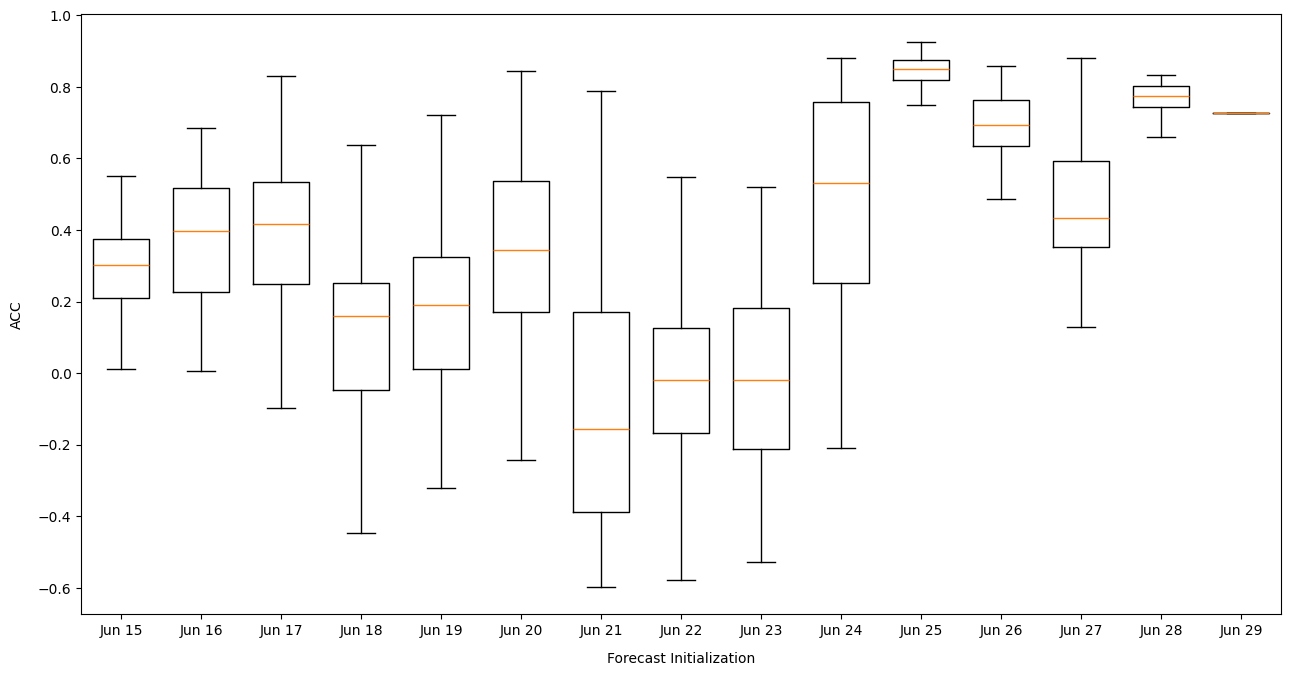

In [69]:
#use this a this simple check before you create larger plot
plot_acc_boxplot(acc_fcnv1_era_t850_box_0629_ens.T)

In [80]:
#creating the panel box plot on top of the three models ensembles  --write a function here

def plot_acc_boxplot_group(data_ec_ens,data_fcn_era_ens,data_fcn_ec_ens):
    import matplotlib.pyplot as pl
    #%store -r data_array_fc_ec_values_850hpa
    colors = [ 'lightblue','lightgreen','lightpink']
    plt.figure(figsize=(12, 6))
    
    # we compare the performances of the 4 individuals within the same set of 3 settings 
    data_groups = [data_ec_ens.T,data_fcn_era_ens.T,data_fcn_ec_ens.T]
    #np.shape(data_groups)
    
    
    # --- Labels for your data:
    labels_list = ['06-15','06-16','06-17','06-18','06-19','06-20','06-21','06-22','06-23','06-24','06-25','06-26','06-27','06-28','06-29']
    width       = 1/len(labels_list)
    width
    
    xlocations  = [ x*((1+ len(data_groups))*width) for x in range(len(data_ec_ens[:,:])) ]
    xlocations
    
    symbol      = 'r+'
    ymin        = min ( [ val  for dg in data_groups  for data in dg for val in data ] )
    ymax        = max ( [ val  for dg in data_groups  for data in dg for val in data ])
    ymax 
    
    
    
    ax = pl.gca()
    ax.set_ylim(-1,1.5)
    ax.grid(True, linestyle='dotted')
    ax.set_axisbelow(True)
    
    pl.xlabel('Forecast Initialization')
    pl.ylabel('ACC')
    #pl.title('title')
    
    space = len(data_groups)/2
    offset = len(data_groups)/2
    offset
    
    xlocations
    
    # --- Offset the positions per group:
    
    group_positions = []
    for num, dg in enumerate(data_groups):    
        _off = (0 - space + (0.5+num))
        print(_off)
        group_positions.append([x+_off*(width+0.01) for x in xlocations])
    
    group_positions
    
    data_groups
    len(labels_list)
    
    for dg, pos, c in zip(data_groups, group_positions, colors):
        boxes = ax.boxplot(dg, 
                    sym=symbol,
                    labels=['']*len(labels_list),
        #            labels=labels_list,
                    positions=pos, 
                    widths=width, 
                    boxprops=dict(facecolor=c),
        #             capprops=dict(color=c),
        #            whiskerprops=dict(color=c),
        #            flierprops=dict(color=c, markeredgecolor=c),                       
                    medianprops=dict(color='grey'),
        #           notch=False,  
        #           vert=True, 
        #           whis=1.5,
        #           bootstrap=None, 
        #           usermedians=None, 
        #           conf_intervals=None,
                    patch_artist=True,showfliers=False
                    )
    #%store -r mean_era5_06_29
    #line_artists = []
    #line = plt.axhline(y=ds_era_z500_mean/9.80665, color='r', linestyle='-',label = 'ERA5')
    #line_artists.append(line)
    
    
    ax.set_xticks( xlocations )
    ax.set_xticklabels( labels_list, rotation=45 )
    
    
    legend_labels = ['ECMWF','FourCastnNet(ERA5)','FourCastnNet(ECMWF)']
    legend_handles = [plt.Line2D([0], [0],marker='o', color='w', label=label, markersize=10, markerfacecolor=color) for label, color in zip(legend_labels[:], colors) ]#+ line_artists 
    plt.legend(handles=legend_handles, loc='lower right')
    #plt.title('whole area')
    #plt.savefig('/home/kit/imk-tro/gj5173/21.09_boxplot/850_ts_ensemble_3togther.png', bbox_inches='tight',dpi=100)
    
    pl.show()


In [1]:
#creating the panel box plot with cf on top of the three models ensemble  -- write a function here

def plot_acc_boxplot_group_cfplus(data_ec_ens,data_fcn_era_ens,data_fcn_ec_ens,data_ec_cf,data_fcn_era_cf,data_fcn_ec_cf):
    import matplotlib.pyplot as pl
    #%store -r data_array_fc_ec_values_850hpa
    colors = [ 'lightblue','lightgreen','lightpink']
    plt.figure(figsize=(12, 6))
    
    # we compare the performances of the 4 individuals within the same set of 3 settings 
    data_groups = [data_ec_ens.T,data_fcn_era_ens.T,data_fcn_ec_ens.T]
    #np.shape(data_groups)
    
    
    # --- Labels for your data:
    labels_list = ['06-15','06-16','06-17','06-18','06-19','06-20','06-21','06-22','06-23','06-24','06-25','06-26','06-27','06-28','06-29']
    width       = 1/len(labels_list)
    width
    
    
    
    
    
    xlocations  = [ x*((1+ len(data_groups))*width) for x in range(len(data_ec_ens[:,:])) ]
    xlocations
    
    symbol      = 'r+'
    ymin        = min ( [ val  for dg in data_groups  for data in dg for val in data ] )
    ymax        = max ( [ val  for dg in data_groups  for data in dg for val in data ])
    ymax 
    
    
    
    ax = pl.gca()
    ax.set_ylim(-1,1.5)
    ax.grid(True, linestyle='dotted')
    ax.set_axisbelow(True)
    
    pl.xlabel('Forecast Initialization')
    pl.ylabel('ACC')
    #pl.title('title')
    
    space = len(data_groups)/2
    offset = len(data_groups)/2
    offset
    
    xlocations
    
    # --- Offset the positions per group:
    
    group_positions = []
    for num, dg in enumerate(data_groups):    
        _off = (0 - space + (0.5+num))
        print(_off)
        group_positions.append([x+_off*(width+0.01) for x in xlocations])
    
    
    
    data_groups
    len(labels_list)
    
    for dg, pos, c in zip(data_groups, group_positions, colors):
        boxes = ax.boxplot(dg, 
                    sym=symbol,
                    labels=['']*len(labels_list),
        #            labels=labels_list,
                    positions=pos, 
                    widths=width, 
                    boxprops=dict(facecolor=c),
        #             capprops=dict(color=c),
        #            whiskerprops=dict(color=c),
        #            flierprops=dict(color=c, markeredgecolor=c),                       
                    medianprops=dict(color='grey'),
        #           notch=False,  
        #           vert=True, 
        #           whis=1.5,
        #           bootstrap=None, 
        #           usermedians=None, 
        #           conf_intervals=None,
                    patch_artist=True,showfliers=False,zorder=2
                    )
    
    #%store -r mean_era5_06_29
    #line_artists = []
    #line = plt.axhline(y=ds_era_z500_mean/9.80665, color='r', linestyle='-',label = 'ERA5')
    #line_artists.append(line)
    
    
    ax.set_xticks( xlocations )
    ax.set_xticklabels( labels_list, rotation=45 )
    point_artists = []
    points_1 = ax.scatter(group_positions[0],data_ec_cf,color='darkblue',zorder = 5,s =15,label = 'CF_EC')
    points_2 = ax.scatter(group_positions[2],data_fcn_ec_cf,color='brown',zorder = 5,s =15,label = 'CF_FCN(EC)')
    points_3 = ax.scatter(group_positions[1],data_fcn_era_cf,color='orange',zorder = 5,s =15,label = 'CF_FCN(ERA)')
    point_artists.append(points_1)
    point_artists.append(points_2)
    point_artists.append(points_3)
    
    legend_labels = ['ECMWF','FourCastnNet(ERA5)','FourCastnNet(ECMWF)','CF_EC','CF_FCN(ERA)']
    legend_handles = [plt.Line2D([0], [0],marker='o', color='w', label=label, markersize=10, markerfacecolor=color) for label, color in zip(legend_labels[:], colors) ]+ point_artists 
    plt.legend(handles=legend_handles, loc='lower right')
    #plt.title('whole area')
    #plt.savefig('/home/kit/imk-tro/gj5173/13.10-plots/z500_ACC_box.png', bbox_inches='tight',dpi=100)
    
    pl.show()

-1.0
0.0
1.0


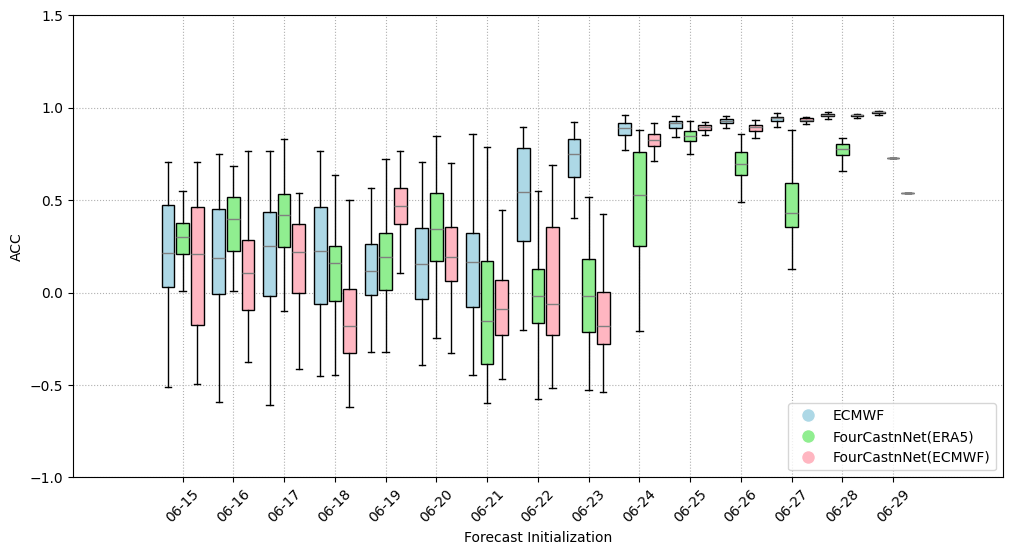

In [82]:
plot_acc_boxplot_group(acc_ec_t850_box_0629_ens,acc_fcnv1_era_t850_box_0629_ens,acc_fcnv1_ec_t850_box_0629_ens)

-1.0
0.0
1.0


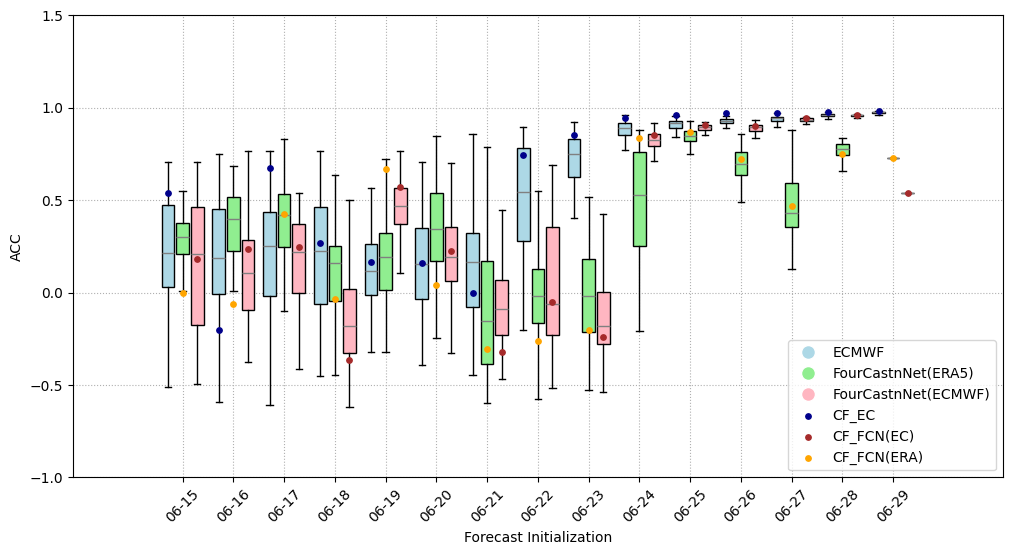

In [6]:
plot_acc_boxplot_group_cfplus(acc_ec_t850_box_0629_ens,acc_fcnv1_era_t850_box_0629_ens,acc_fcnv1_ec_t850_box_0629_ens,acc_ec_t850_box_0629,acc_fcnv1_era_t850_box_0629,acc_fcnv1_ec_t850_box_0629)